In [6]:
import numpy as np
import matplotlib.pyplot as plt

class RNNFromScratch:
    def __init__(self, data, hidden_size=16, seq_length=5, learning_rate=1e-1):
        self.data = data
        self.chars = list(set(data))
        self.vocab_size = len(self.chars)
        self.char_to_ix = {ch: i for i, ch in enumerate(self.chars)}
        self.ix_to_char = {i: ch for i, ch in enumerate(self.chars)}

        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.learning_rate = learning_rate

        # Model parameters
        self.Wxh = np.random.randn(hidden_size, self.vocab_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(self.vocab_size, hidden_size) * 0.01
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((self.vocab_size, 1))

        # For loss tracking
        self.losses = []

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x, axis=0)

    def sample(self, seed_ix, n=10):
        x = np.zeros((self.vocab_size, 1))
        x[seed_ix] = 1
        h = np.zeros((self.hidden_size, 1))
        ixes = []
        for _ in range(n):
            h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
            y = np.dot(self.Why, h) + self.by
            p = self.softmax(y)
            ix = np.random.choice(range(self.vocab_size), p=p.ravel())
            x = np.zeros((self.vocab_size, 1))
            x[ix] = 1
            ixes.append(ix)
        return ''.join(self.ix_to_char[ix] for ix in ixes)

    def train(self, iterations=1000, print_every=100):
        p = 0
        data_size = len(self.data)

        for n in range(iterations):
            if p + self.seq_length + 1 >= data_size:
                p = 0
            inputs = [self.char_to_ix[ch] for ch in self.data[p:p + self.seq_length]]
            targets = [self.char_to_ix[ch] for ch in self.data[p + 1:p + self.seq_length + 1]]

            xs, hs, ys, ps = {}, {}, {}, {}
            hs[-1] = np.zeros((self.hidden_size, 1))
            loss = 0

            # Forward pass
            for t in range(self.seq_length):
                xs[t] = np.zeros((self.vocab_size, 1))
                xs[t][inputs[t]] = 1
                hs[t] = np.tanh(np.dot(self.Wxh, xs[t]) + np.dot(self.Whh, hs[t - 1]) + self.bh)
                ys[t] = np.dot(self.Why, hs[t]) + self.by
                ps[t] = self.softmax(ys[t])
                loss += -np.log(ps[t][targets[t], 0])

            # Backward pass
            dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
            dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
            dhnext = np.zeros_like(hs[0])

            for t in reversed(range(self.seq_length)):
                dy = np.copy(ps[t])
                dy[targets[t]] -= 1
                dWhy += np.dot(dy, hs[t].T)
                dby += dy
                dh = np.dot(self.Why.T, dy) + dhnext
                dhraw = (1 - hs[t] ** 2) * dh
                dbh += dhraw
                dWxh += np.dot(dhraw, xs[t].T)
                dWhh += np.dot(dhraw, hs[t - 1].T)
                dhnext = np.dot(self.Whh.T, dhraw)

            # Gradient clipping
            for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
                np.clip(dparam, -5, 5, out=dparam)

            # Update weights
            for param, dparam in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by],
                                     [dWxh, dWhh, dWhy, dbh, dby]):
                param -= self.learning_rate * dparam

            # Track loss
            self.losses.append(loss)

            if n % print_every == 0:
                print(f"Iteration {n}, Loss: {loss:.4f}")
                sample = self.sample(inputs[0], n=10)
                print(f"Sample: {sample}\n")

            p += self.seq_length

    def plot_loss(self):
        plt.figure(figsize=(8, 4))
        plt.plot(self.losses, label="Training Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.title("RNN Training Loss Over Time")
        plt.grid(True)
        plt.legend()
        plt.show()


Iteration 0, Loss: 6.9315
Sample: eoheeloeee

Iteration 100, Loss: 0.0749
Sample: ellohelloh

Iteration 200, Loss: 0.0259
Sample: ellohelloh

Iteration 300, Loss: 0.0153
Sample: ellohelloh

Iteration 400, Loss: 0.0108
Sample: ellohelloh

Iteration 500, Loss: 0.0083
Sample: ellohelloh

Iteration 600, Loss: 0.0068
Sample: ellohelloh

Iteration 700, Loss: 0.0057
Sample: ellohelloh

Iteration 800, Loss: 0.0049
Sample: ellohelloh

Iteration 900, Loss: 0.0043
Sample: ellohelloh



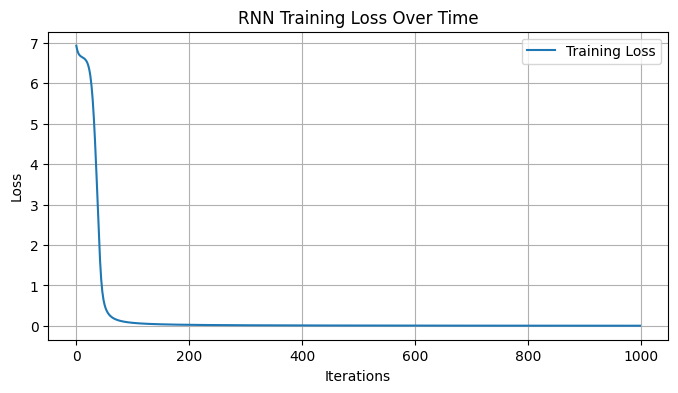

In [7]:
rnn = RNNFromScratch("hellohellohello", hidden_size=16, seq_length=5, learning_rate=0.1)
rnn.train(iterations=1000, print_every=100)
rnn.plot_loss()
